(two-means-notebook)=
# Test t di Student per campioni indipendenti 

In questo capitolo, esamineremo il test $t$ di Student per campioni indipendenti, uno dei test statistici frequentisti più ampiamente utilizzati nella pratica.

## Preparazione del Notebook

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind
import arviz as az
import seaborn as sns
import itertools
import pingouin as pg

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Applicazioni del Test t di Student

Il test t di Student per due campioni indipendenti è un metodo statistico utilizzato per determinare se le medie di due campioni indipendenti sono significativamente diverse. Questo test si applica quando i due campioni sono estratti da popolazioni diverse e non vi è alcuna correlazione tra le osservazioni di un campione e quelle dell'altro.

Per condurre il test t di Student per due campioni indipendenti, calcoliamo la differenza tra le medie dei due campioni e le stime delle varianze campionarie delle rispettive popolazioni. L'ipotesi nulla del test è che le medie dei due campioni siano uguali, mentre l'ipotesi alternativa a due code è che le medie dei due campioni siano diverse. La statistica del test t viene calcolata come il rapporto tra la differenza delle medie campionarie e la deviazione standard media campionaria.

Successivamente, confrontiamo la statistica t con la distribuzione t di Student con $n_1 + n_2 - 2$ gradi di libertà, dove $n_1$ e $n_2$ sono le dimensioni dei due campioni. Calcoliamo quindi il valore-p dalla distribuzione t per determinare la significatività del test.

Esistono due approcci per stimare la varianza. Se assumiamo che le due popolazioni abbiano la stessa varianza (omoschedasticità), utilizziamo una stima *pooled* della varianza. Questo metodo è considerato efficiente quando l'omoschedasticità è verificata (argomento `correction = False` in `pg.ttest()`). Invece, se supponiamo che le due popolazioni abbiano varianze diverse, utilizziamo due stime separate delle varianze per i due campioni, chiamato test di Welch (argomento `correction = True` in `pg.ttest()`). Questo approccio è più robusto quando le varianze dei due gruppi sono significativamente diverse.

Le principali assunzioni del test t di Student per due campioni indipendenti sono l'indipendenza dei due campioni e la normalità della distribuzione delle popolazioni da cui sono stati estratti i campioni.

Di seguito è riportato il calcolo della stima della deviazione standard *pooled*, utilizzata per standardizzare la differenza tra le medie dei due campioni quando l'assunzione di omoschedasticità è verificata:

$$
s_p = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}},
$$

dove $s_p$ è la deviazione standard *pooled*, $n$ e $m$ sono le dimensioni dei due campioni, $s^2_0$ e $s^2_1$ sono le varianze campionarie dei due gruppi.

La statistica del test t è quindi calcolata come:

$$
t = \frac{\bar{x}_1 - \bar{x}_2}{s_p \sqrt{1/n_1 + 1/n_2}},
$$

dove $\bar{x}_1$ e $\bar{x}_2$ sono le medie campionarie dei due gruppi. 

### Dimostrazione

Per dimostrare come calcolare la varianza della differenza tra due medie campionarie, supponiamo di avere due campioni casuali indipendenti $X_1, X_2, \dots, X_n$ e $Y_1, Y_2, \dots, Y_m$ che sono estratti dalla stessa popolazione con media $\mu$ e varianza $\sigma^2$. Definiamo $\bar{X}$ e $\bar{Y}$ come le medie campionarie di questi due campioni, rispettivamente.

Le medie campionarie $\bar{X}$ e $\bar{Y}$ sono date da:
$$
\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i
$$
$$
\bar{Y} = \frac{1}{m} \sum_{j=1}^m Y_j
$$

Le medie campionarie $\bar{X}$ e $\bar{Y}$ sono entrambe stimatori non distorti della media della popolazione $\mu$. Le loro varianze sono date da:

$$
\text{Var}(\bar{X}) = \frac{\sigma^2}{n}
$$

$$
\text{Var}(\bar{Y}) = \frac{\sigma^2}{m}
$$

Siamo interessati a calcolare la varianza della differenza $\bar{X} - \bar{Y}$. Utilizzando le proprietà di varianza per combinazioni lineari di variabili aleatorie indipendenti, otteniamo:

$$
\text{Var}(\bar{X} - \bar{Y}) = \text{Var}(\bar{X}) + \text{Var}(\bar{Y})
$$

dato che i termini incrociati si annullano per l'indipendenza di $\bar{X}$ e $\bar{Y}$. Sostituendo le varianze di $\bar{X}$ e $\bar{Y}$ abbiamo:

$$
\text{Var}(\bar{X} - \bar{Y}) = \frac{\sigma^2}{n} + \frac{\sigma^2}{m}
$$

$$
\text{Var}(\bar{X} - \bar{Y}) = \sigma^2 \left(\frac{1}{n} + \frac{1}{m}\right)
$$

Quindi, la varianza della differenza tra le due medie campionarie è una combinazione delle varianze delle singole medie, ponderate in base alle dimensioni dei campioni corrispondenti.

Per giungere alla formula del test $t$ di Student per due campioni indipendenti dobbiamo considerare l'incertezza aggiuntiva che deriva dal fatto che non conosciamo $\sigma$. Il modo migliore di stimare $\sigma$ è quello di utilizzare le due deviazioni standard dei campioni (calcolate come stimatori della varianza della popolazione) ponderate per i rispettivi gradi di libertà, come indicato in precedenza per la deviazione standard *pooled*:

$$
s_p = \sqrt{\frac{(n - 1)s^2_x + (m - 1)s^2_y}{n + m - 2}},
$$

dove $s_x$ e $s_y$ sono le deviazioni standard dei due campioni, e $n$ e $m$ sono le numerosità dei due campioni. 

### Un esempio concreto

Esaminiamo un esempio concreto. Supponiamo di disporre di nove misure del peso per un gruppo di donne e di nove misure di peso per un gruppo di uomini. Ci chiediamo se, nella popolazione, la media del peso dei due gruppi sia diversa.

Creiamo due array con i dati e li inseriamo in un DataFrame.

In [5]:
women_weight = np.array([38.9, 61.2, 73.3, 21.8, 63.4, 64.6, 48.4, 48.8, 48.5])
men_weight = np.array([67.8, 60, 63.4, 76, 89.4, 73.3, 67.3, 61.3, 62.4])

weight = np.concatenate((women_weight, men_weight))
print(weight)

[38.9 61.2 73.3 21.8 63.4 64.6 48.4 48.8 48.5 67.8 60.  63.4 76.  89.4
 73.3 67.3 61.3 62.4]


Creaiamo una variabile che specifica l'appartenenza al gruppo.

In [6]:
is_female = np.repeat([1, 0], 9)
is_female

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
df = pd.DataFrame({"is_female": is_female, "weight": weight})
df

,is_female,weight
0,1,38.9
1,1,61.2
2,1,73.3
3,1,21.8
4,1,63.4
5,1,64.6
6,1,48.4
7,1,48.8
8,1,48.5
9,0,67.8


Qui sotto è riportato un KDE plot per i dati di tutto il campione.

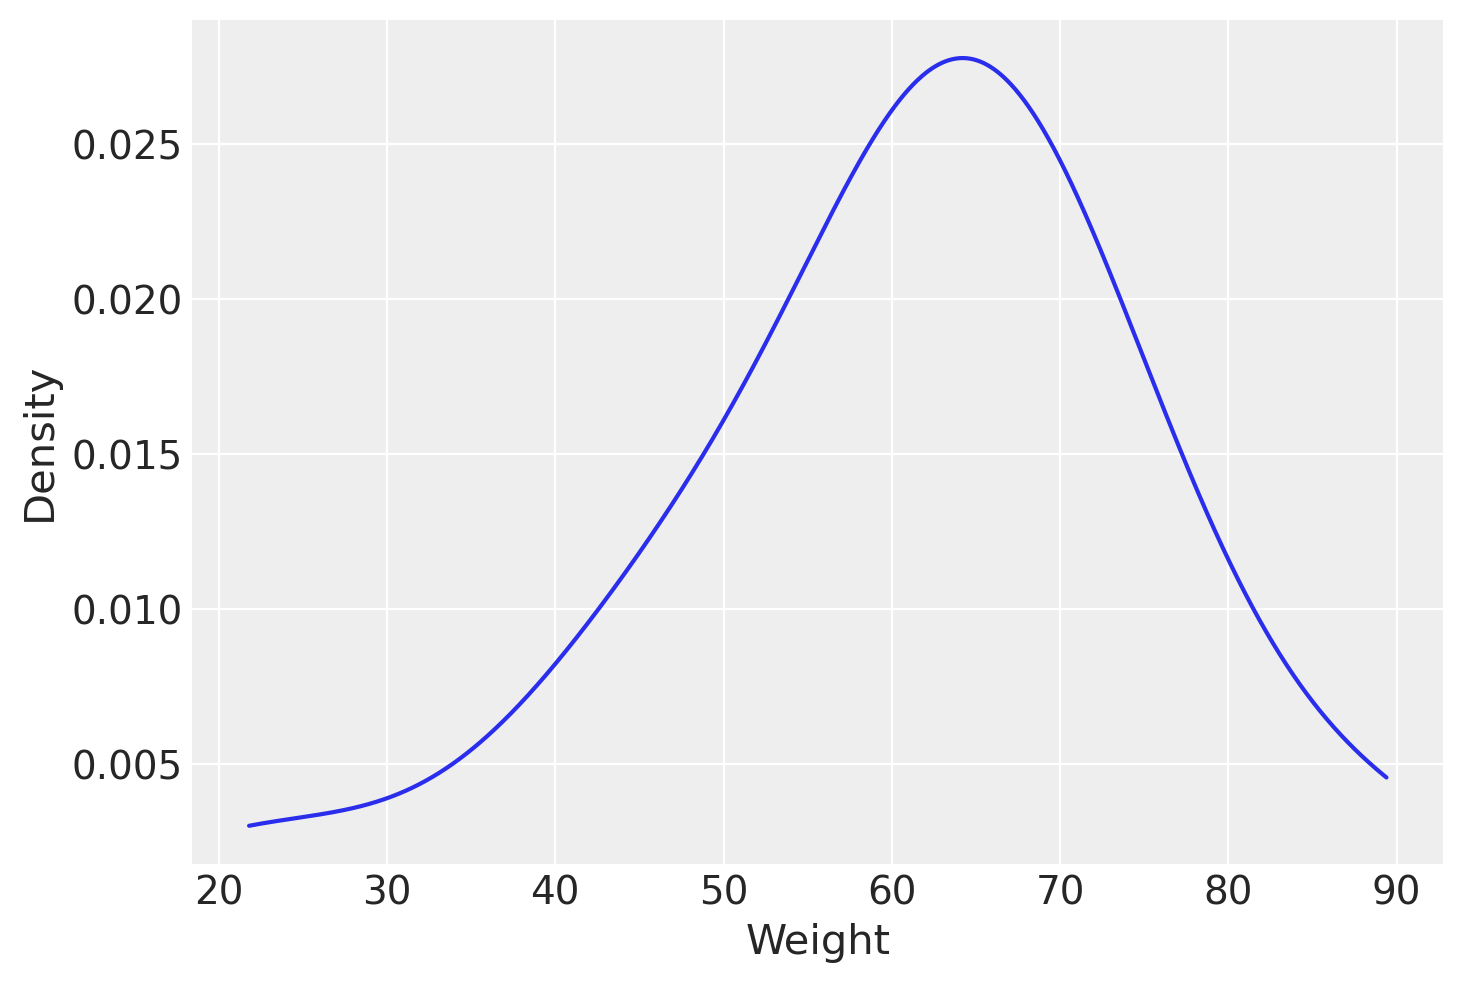

In [8]:
density = gaussian_kde(df["weight"])
x_vals = np.linspace(min(df["weight"]), max(df["weight"]), 1000)
density = density.evaluate(x_vals)

plt.plot(x_vals, density)
plt.xlabel('Weight')
_ = plt.ylabel('Density')

Dal DataFrame estraiamo due array contenenti i valori dei pesi dei due gruppi.

In [9]:
weight_f = df.loc[df["is_female"] == 1, "weight"]
weight_m = df.loc[df["is_female"] == 0, "weight"]

Calcoliamo la deviazione standard *pooled*.

In [10]:
s_pool_num = np.sum(
    [
        (len(weight_f) - 1) * np.std(weight_f, ddof=1) ** 2,
        (len(weight_m) - 1) * np.std(weight_m, ddof=1) ** 2,
    ]
)
s_pool_denom = len(weight_f) + len(weight_m) - 2

s_pool = np.sqrt(np.divide(s_pool_num, s_pool_denom))
s_pool

12.86771368796942

Calcoliamo la statistica test.

In [11]:
t_num = np.mean(weight_f) - np.mean(weight_m)
t_denom = s_pool * np.sqrt(1 / len(weight_f) + 1 / len(weight_m))
T = np.divide(t_num, t_denom)
T

-2.7842353699254567

I gradi di libertà sono:

In [12]:
len(weight_f) + len(weight_m) - 2

16

Il valore-p è uguale a

In [13]:
stats.t.cdf(T, df=16) * 2

0.013265602643801042

Rifacciamo ora i calcoli usando la funzione `ttest` del pacchatto `pingouin`. L'argomento `paired = False` specifica che i due campioni sono indipendenti; l'argomento `correction=False` specifica che non verrà usata la correzione di Welch per varianze separate.

In [14]:
res = pg.ttest(weight_m, weight_f, paired=False, correction=False)
print(res)

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  2.784235   16   two-sided  0.013266  [4.03, 29.75]  1.312501  4.251   

           power  
T-test  0.743519  


Il risultato conferma quanto trovato in precedenza attraverso i calcoli effettuati. Il valore-$p$ indica che possiamo rifiutare l'ipotesi nulla di uguaglianza delle medie delle due popolazioni. Quindi, possiamo concludere con un livello di confidenza del 95% che la media del peso dei maschi nella popolazione è superiore alla media del peso delle femmine nella popolazione.

Se vogliamo un test più robusto, che non assume l'omogeneità delle varianze, usiamo la correzione di Welch:

In [15]:
res = pg.ttest(weight_m, weight_f, paired=False, correction=True)
print(res)

               T        dof alternative     p-val         CI95%   cohen-d  \
T-test  2.784235  13.113752   two-sided  0.015384  [3.8, 29.98]  1.312501   

         BF10     power  
T-test  4.251  0.743519  


La statistica test resta immutata. Quello che cambiano sono i gradi di libertà. Con questa correzione dei gradi di libertà, il p-valore diventa più grande.

## Interpretazione dei Risultati

Il test t di Student per campioni indipendenti ha generato un p-valore di 0.013, inferiore alla soglia di significatività di α = 0.05. Questo indica che la differenza osservata tra i gruppi è statisticamente significativa. Tuttavia, anziché limitarci a etichettare il risultato come "statisticamente significativo", è importante considerare cosa implica questo esito nel contesto della ricerca.

In sostanza, il basso p-valore ci porta a rifiutare l'ipotesi nulla, suggerendo che è improbabile che le differenze osservate nei dati siano dovute al caso. Questo ci permette di concludere con una certa fiducia che esiste una differenza reale tra le medie delle popolazioni da cui i campioni sono stati estratti. Questa interpretazione apre la strada a ulteriori indagini sulle cause di tale differenza e sulle loro implicazioni teoriche o pratiche.

Se il p-valore fosse stato superiore alla soglia di significatività α, avremmo interpretato il risultato in modo diverso. Un p-valore maggiore di α indica che i dati osservati non sono incompatibili con l'ipotesi nulla. In altre parole, non avremmo avuto motivi statistici sufficienti per rifiutare l'ipotesi nulla. Tuttavia, è importante sottolineare che questo non equivale a dimostrare che l'ipotesi nulla sia vera; piuttosto, i dati non forniscono evidenza sufficiente per confutarla.

In pratica, la non rifiutazione dell'ipotesi nulla significa che i dati sono compatibili sia con l'ipotesi nulla sia con altre possibili ipotesi sulle caratteristiche della popolazione. Di conseguenza, in assenza di evidenza contraria, ci asteniamo dal fare affermazioni conclusive e manteniamo una posizione di neutralità riguardo l'ipotesi nulla, rimanendo aperti alla possibilità di ulteriori indagini e dati futuri che potrebbero chiarire meglio la questione.

## Riportare i risultati

Per riportare i risultati si può usare un testo come quello seguente:

> Abbiamo condotto un test $t$ di Student per campioni indipendenti per confrontare le medie dei due gruppi. I risultati indicano una differenza tra le medie dei gruppi ($t$(16) = 2.78, $p$ = 0.013). L'intervallo di confidenza al 95% per la differenza delle medie è tra 4.03 e 29.75. L'ampiezza dell'effetto, misurata con Cohen's $d$, è stata di 1.31, indicando un effetto grande secondo le convenzioni comunemente accettate. La potenza statistica del test, calcolata post hoc, è stata del 74.4%, indicando una buona probabilità di rilevare un effetto, se presente.

## Test Unidirezionali e Bidirezionali

Il criterio secondo il quale un p-valore inferiore a α indica una "significatività statistica" è comune sia nei test bidirezionali sia nei test unidirezionali, ma l'applicazione differisce a seconda della natura dell'ipotesi testata.

### Test Bidirezionale
Nel caso di un test bidirezionale, le ipotesi sono formulate come segue:
- **Ipotesi nulla (H₀):** $\mu_1 = \mu_2$ (cioè, $\mu_1 - \mu_2 = 0$); si assume uguaglianza delle varianze ($\sigma^2_1 = \sigma^2_2$).
- **Ipotesi alternativa (H₁):** $\mu_1 \neq \mu_2$; ancora con uguaglianza delle varianze.

La statistica test è calcolata come $ \bar{Y}_1 - \bar{Y}_2 $, dove $\bar{Y}_1$ e $\bar{Y}_2$ sono le medie campionarie dei due gruppi. La regione di rifiuto dell'ipotesi nulla è equamente divisa tra le due code della distribuzione della statistica test, con α/2 per coda.

### Test Unidirezionale
Per i test unidirezionali, la direzione della differenza che si sta testando è cruciale:

1. **Quando si testa se $\mu_1$ è minore di $\mu_2$:**
   - **Ipotesi nulla (H₀):** $\mu_1 \geq \mu_2$;
   - **Ipotesi alternativa (H₁):** $\mu_1 < \mu_2$.

   La statistica test è calcolata come $ \bar{Y}_1 - \bar{Y}_2 $. Se questa differenza è significativamente negativa (cioè cade nella coda sinistra oltre il valore critico), supporta H₁.

2. **Quando si testa se $\mu_1$ è maggiore di $\mu_2$:**
   - **Ipotesi nulla (H₀):** $\mu_1 \leq \mu_2$;
   - **Ipotesi alternativa (H₁):** $\mu_1 > \mu_2$.

   Anche qui, la statistica test è $ \bar{Y}_1 - \bar{Y}_2 $. Un risultato che supera il valore critico nella coda destra indica supporto per H₁.

In ogni tipo di test unidirezionale, la regione di rifiuto occupa l'intero α dell'area sotto la curva di densità, ma è posizionata completamente nella coda specificata dall'ipotesi alternativa.

## Considerazioni sugli Errori di Tipo I e Tipo II

La scelta di un livello di significatività $\alpha = 0.05$ implica che, nel contesto di un test d'ipotesi, esiste una probabilità del 5% di commettere un errore di Tipo I. Questo tipo di errore si verifica quando l'ipotesi nulla è vera ma, a causa della variabilità casuale nei dati del campione, otteniamo risultati abbastanza estremi da rifiutare erroneamente $H_0$. 

Un errore di Tipo II, invece, si verifica quando l'ipotesi nulla è falsa, ma i dati del campione non sono sufficientemente estremi da giustificare il suo rifiuto. La probabilità di commettere un errore di Tipo II è spesso influenzata dalla dimensione del campione: campioni più piccoli tendono ad avere una potenza statistica inferiore, aumentando il rischio di non rifiutare $H_0$ quando sarebbe appropriato farlo. La potenza statistica di un test, che rappresenta la probabilità di rifiutare correttamente l'ipotesi nulla quando è falsa, può essere stimata, ma questa stima può diventare complessa. 

Per i modelli statistici complessi, la stima della potenza può essere particolarmente difficile. Non solo i calcoli possono essere intricati, ma non esiste un metodo unico e standardizzato per effettuare tali stime, richiedendo l'introduzione di diverse assunzioni. 

La funzione `ttest` del pacchetto `pingouin` offre un modo per calcolare la potenza di un test in contesti di test statistici relativamente semplici.

## Informazioni sull'Ambiente di Sviluppo

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Mon May 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pingouin  : 0.5.4
matplotlib: 3.8.4
pandas    : 2.2.2
seaborn   : 0.13.2
scipy     : 1.13.0
arviz     : 0.18.0
numpy     : 1.26.4

Watermark: 2.4.3

